# word2vec 유사도 시각화 

- http://blog.daum.net/geoscience/1414

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
import datetime
%matplotlib inline

In [26]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-10-24 10:48:16,692 : INFO : Generating new fontManager, this may take some time...
2020-10-24 10:48:17,230 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
2020-10-24 10:48:17,456 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
2020-10-24 10:48:17,490 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)


In [3]:
gender = pd.read_csv('whole-gender-bill-1320.csv', index_col=0,
                           parse_dates=['제안일자','의결일자'],encoding='utf-8-sig')
print(gender.shape)
gender.head(1)

(4295, 16)


,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자,발의자,제안정당,성별,여성의원 수,정당성향,국회회기
0,131131,소득세법중개정법률안,1990-12-17,위원장,1990-12-18,원안가결,제13대 (1988~1992) 제151회,"정부제출,柳인학·강金식·금봉욱·林춘원·李경재·허만기·홍영기의원외64인 발의,1...",재무위원회,[],위원장,위원장,NaN,0,NaN,13


In [4]:
gender['제안일자'] = gender['제안일자'].dt.date
gender['의결일자'] = gender['의결일자'].dt.date

In [5]:
gender['제안일자'].unique()

array([datetime.date(1990, 12, 17), datetime.date(1990, 11, 20),
       datetime.date(1990, 10, 8), ..., datetime.date(2016, 6, 1),
       datetime.date(2016, 5, 31), datetime.date(2016, 5, 30)],
      dtype=object)

In [6]:
drop_list = [177919, 177064, 176854, 176797, 176796, 176795, 176794]

gender = gender[~gender['의안번호'].isin(drop_list)]
gender.shape

(4288, 16)

## 정부별 wordcloud

In [7]:
gender['제안자구분'].value_counts()

의원     3766
위원장     344
정부      178
Name: 제안자구분, dtype: int64

In [8]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명','보장하',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자',
            '조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출']

    text = [word for word in text if word not in stopwords]
    return text

In [9]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [10]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 299 ms, sys: 5.21 ms, total: 305 ms
Wall time: 324 ms


In [11]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [12]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 2min 59s, sys: 1.64 s, total: 3min
Wall time: 2min 46s


0    [소득세법중개정법률, 정부제출, 인학, 금봉욱, 춘원, 경재, 허만기, 홍영기의원외...
1    [특정범죄가중처벌등에관한법률중개정법률안, 정부, 제출, 각특정범죄가중처벌등에관한법률...
2    [유아의보호, 교육에관한법률안, 현대사회, 산업화, 여성, 사회참여, 가족구조, 핵...
Name: tokens, dtype: object

In [13]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 1.46 s, sys: 16.2 ms, total: 1.48 s
Wall time: 1.52 s


In [14]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.89 ms, sys: 167 µs, total: 2.06 ms
Wall time: 1.94 ms


In [15]:
# 명사 수가 10개를 넘어가는 경우만 추출
#gender = gender[gender['명사수'] >= 10]
#gender = gender.reset_index(drop=True)
#print(gender.shape)

In [16]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs, model):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

## 정권 탐색 

### 노태우 정권 
- 1998.02.25 ~ 1993.02.24

In [47]:
notaewoo = gender[(gender['제안일자'] > datetime.date(1988,5,3)) & 
                        (gender['제안일자'] < datetime.date(1993,2,24))]
notaewoo.shape

(23, 19)

In [48]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [49]:
model_government = Word2Vec(notaewoo['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=1)

2020-10-24 11:00:21,155 : INFO : collecting all words and their counts
2020-10-24 11:00:21,158 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-24 11:00:21,161 : INFO : collected 2125 word types from a corpus of 4293 raw words and 23 sentences
2020-10-24 11:00:21,162 : INFO : Loading a fresh vocabulary
2020-10-24 11:00:21,165 : INFO : effective_min_count=10 retains 41 unique words (1% of original 2125, drops 2084)
2020-10-24 11:00:21,166 : INFO : effective_min_count=10 leaves 627 word corpus (14% of original 4293, drops 3666)
2020-10-24 11:00:21,168 : INFO : deleting the raw counts dictionary of 2125 items
2020-10-24 11:00:21,169 : INFO : sample=0.001 downsamples 41 most-common words
2020-10-24 11:00:21,170 : INFO : downsampling leaves estimated 151 word corpus (24.1% of prior 627)
2020-10-24 11:00:21,171 : INFO : estimated required memory for 41 words and 100 dimensions: 53300 bytes
2020-10-24 11:00:21,172 : INFO : resetting layer weights
2020-10-24 1

2020-10-24 11:00:21,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:21,339 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:21,340 : INFO : EPOCH - 15 : training on 4293 raw words (156 effective words) took 0.0s, 51469 effective words/s
2020-10-24 11:00:21,343 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:21,344 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:21,345 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:21,346 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:21,346 : INFO : EPOCH - 16 : training on 4293 raw words (168 effective words) took 0.0s, 62503 effective words/s
2020-10-24 11:00:21,349 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:21,351 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 1

2020-10-24 11:00:21,529 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:21,530 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:21,532 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:21,534 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:21,535 : INFO : EPOCH - 32 : training on 4293 raw words (127 effective words) took 0.0s, 20199 effective words/s
2020-10-24 11:00:21,539 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:21,540 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:21,543 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:21,544 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:21,546 : INFO : EPOCH - 33 : training on 4293 raw words (151 effective words) took 0.0s, 18546 effective words/s
2020-10-24 1

2020-10-24 11:00:21,723 : INFO : EPOCH - 48 : training on 4293 raw words (155 effective words) took 0.0s, 25178 effective words/s
2020-10-24 11:00:21,729 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:21,731 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:21,733 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:21,734 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:21,736 : INFO : EPOCH - 49 : training on 4293 raw words (165 effective words) took 0.0s, 19397 effective words/s
2020-10-24 11:00:21,742 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:21,744 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:21,745 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:21,746 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 1

2020-10-24 11:00:21,964 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:21,966 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:21,967 : INFO : EPOCH - 65 : training on 4293 raw words (164 effective words) took 0.0s, 19898 effective words/s
2020-10-24 11:00:21,971 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:21,973 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:21,975 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:21,977 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:21,978 : INFO : EPOCH - 66 : training on 4293 raw words (176 effective words) took 0.0s, 24970 effective words/s
2020-10-24 11:00:21,982 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:21,983 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 1

2020-10-24 11:00:22,123 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:22,125 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:22,127 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:22,128 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:22,129 : INFO : EPOCH - 82 : training on 4293 raw words (163 effective words) took 0.0s, 27094 effective words/s
2020-10-24 11:00:22,134 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:22,135 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:22,137 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:22,140 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:22,141 : INFO : EPOCH - 83 : training on 4293 raw words (144 effective words) took 0.0s, 19869 effective words/s
2020-10-24 1

2020-10-24 11:00:22,327 : INFO : EPOCH - 98 : training on 4293 raw words (148 effective words) took 0.0s, 20518 effective words/s
2020-10-24 11:00:22,340 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:22,344 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:22,350 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:22,357 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:22,359 : INFO : EPOCH - 99 : training on 4293 raw words (177 effective words) took 0.0s, 8313 effective words/s
2020-10-24 11:00:22,375 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:22,378 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:22,381 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:22,383 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11

In [50]:
print(model_government.wv.most_similar('여성'))

2020-10-24 11:00:22,463 : INFO : precomputing L2-norms of word weight vectors


[('성폭력범죄', 0.9836685061454773), ('사회', 0.8852907419204712), ('피해자', 0.8695561289787292), ('보호', 0.8350968360900879), ('가중처벌', 0.7857950925827026), ('범죄', 0.7844200134277344), ('미성년자', 0.7648455500602722), ('지방자치단체', 0.7576465606689453), ('처벌', 0.7264265418052673), ('보육시설', 0.6712808012962341)]


In [51]:
df = pd.DataFrame(model_government.wv.most_similar("여성", topn=20), columns=['단어','유사도'])
df.head(10)

,단어,유사도
0,성폭력범죄,0.983669
1,사회,0.885291
2,피해자,0.869556
3,보호,0.835097
4,가중처벌,0.785795
5,범죄,0.784420
6,미성년자,0.764846
7,지방자치단체,0.757647
8,처벌,0.726427
9,보육시설,0.671281


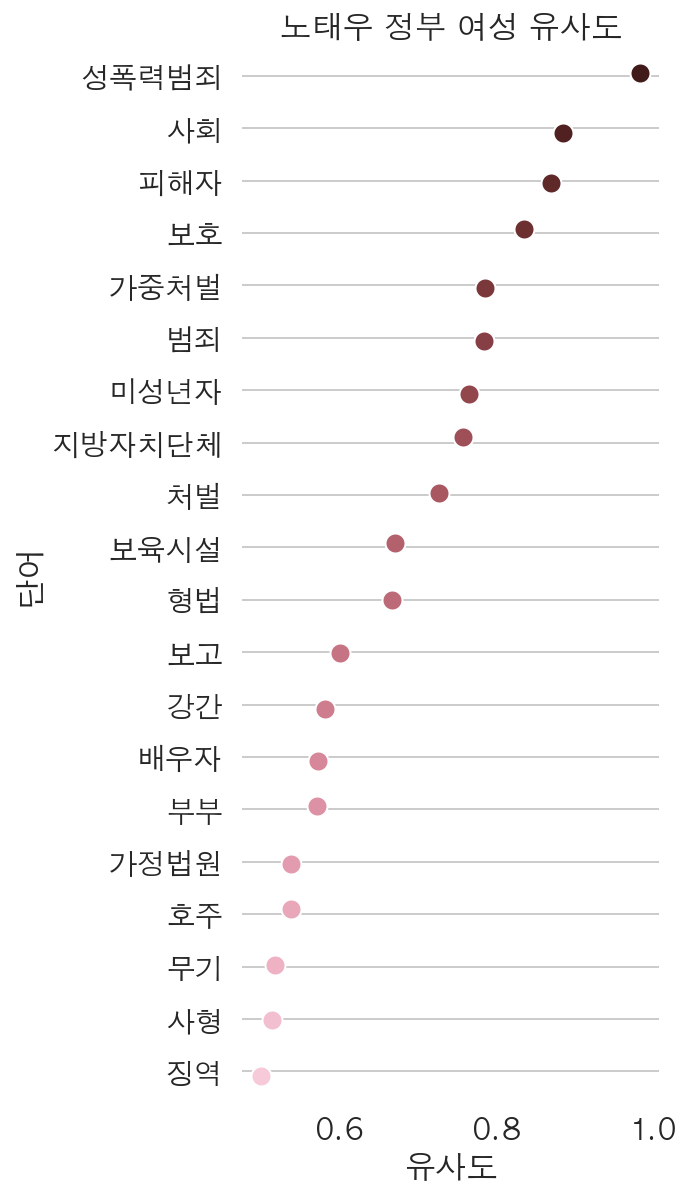

In [52]:
import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df, x_vars=df.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')
#g.set(xlable='유사도', ylabel="")
titles = df.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='노태우 정부 여성 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)
#plt.savefig('김영삼 정권 유사도.png', bbox_inches='tight')

## 김영삼 정권 
- 1993.02.25 ~ 1998.02.24

In [53]:
kimyoungsam = gender[(gender['제안일자'] > datetime.date(1993,2,25)) & 
                        (gender['제안일자'] < datetime.date(1998,2,24))]
kimyoungsam.shape

(62, 19)

In [54]:
model_government = Word2Vec(kimyoungsam['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=1)

2020-10-24 11:00:30,028 : INFO : collecting all words and their counts
2020-10-24 11:00:30,030 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-24 11:00:30,035 : INFO : collected 3134 word types from a corpus of 7797 raw words and 62 sentences
2020-10-24 11:00:30,036 : INFO : Loading a fresh vocabulary
2020-10-24 11:00:30,040 : INFO : effective_min_count=10 retains 118 unique words (3% of original 3134, drops 3016)
2020-10-24 11:00:30,041 : INFO : effective_min_count=10 leaves 2066 word corpus (26% of original 7797, drops 5731)
2020-10-24 11:00:30,043 : INFO : deleting the raw counts dictionary of 3134 items
2020-10-24 11:00:30,044 : INFO : sample=0.001 downsamples 118 most-common words
2020-10-24 11:00:30,045 : INFO : downsampling leaves estimated 928 word corpus (45.0% of prior 2066)
2020-10-24 11:00:30,047 : INFO : estimated required memory for 118 words and 100 dimensions: 153400 bytes
2020-10-24 11:00:30,051 : INFO : resetting layer weights
2020-1

2020-10-24 11:00:30,464 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:30,465 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:30,466 : INFO : EPOCH - 15 : training on 7797 raw words (916 effective words) took 0.0s, 109025 effective words/s
2020-10-24 11:00:30,475 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:30,478 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:30,479 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:30,480 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:30,481 : INFO : EPOCH - 16 : training on 7797 raw words (940 effective words) took 0.0s, 165282 effective words/s
2020-10-24 11:00:30,492 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:30,495 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24

2020-10-24 11:00:30,703 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:30,705 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:30,706 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:30,708 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:30,709 : INFO : EPOCH - 32 : training on 7797 raw words (945 effective words) took 0.0s, 142696 effective words/s
2020-10-24 11:00:30,714 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:30,717 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:30,719 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:30,721 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:30,721 : INFO : EPOCH - 33 : training on 7797 raw words (944 effective words) took 0.0s, 118344 effective words/s
2020-10-24

2020-10-24 11:00:30,951 : INFO : EPOCH - 48 : training on 7797 raw words (932 effective words) took 0.0s, 105208 effective words/s
2020-10-24 11:00:30,967 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:30,974 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:30,977 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:30,981 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:30,984 : INFO : EPOCH - 49 : training on 7797 raw words (936 effective words) took 0.0s, 56673 effective words/s
2020-10-24 11:00:30,991 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:30,999 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:31,001 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:31,002 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 

2020-10-24 11:00:31,296 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:31,297 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:31,299 : INFO : EPOCH - 65 : training on 7797 raw words (993 effective words) took 0.0s, 82016 effective words/s
2020-10-24 11:00:31,311 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:31,315 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:31,318 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:31,322 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:31,324 : INFO : EPOCH - 66 : training on 7797 raw words (939 effective words) took 0.0s, 73049 effective words/s
2020-10-24 11:00:31,339 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:31,350 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 1

2020-10-24 11:00:31,558 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:31,560 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:31,561 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:31,563 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:31,564 : INFO : EPOCH - 82 : training on 7797 raw words (898 effective words) took 0.0s, 146840 effective words/s
2020-10-24 11:00:31,568 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:31,570 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:31,573 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:31,575 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:31,575 : INFO : EPOCH - 83 : training on 7797 raw words (923 effective words) took 0.0s, 129371 effective words/s
2020-10-24

2020-10-24 11:00:31,852 : INFO : EPOCH - 98 : training on 7797 raw words (938 effective words) took 0.0s, 52556 effective words/s
2020-10-24 11:00:31,855 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:31,859 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:31,862 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:31,864 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:00:31,865 : INFO : EPOCH - 99 : training on 7797 raw words (923 effective words) took 0.0s, 90010 effective words/s
2020-10-24 11:00:31,871 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:00:31,872 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:00:31,876 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:00:31,877 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 1

In [55]:
print(model_government.wv.most_similar('여성'))

2020-10-24 11:00:31,890 : INFO : precomputing L2-norms of word weight vectors


[('남녀평등', 0.7749960422515869), ('남녀', 0.7513629198074341), ('촉진', 0.7186230421066284), ('도모', 0.7143005132675171), ('발전', 0.5690715312957764), ('정부', 0.5239245891571045), ('개편', 0.507947564125061), ('전환', 0.5058211088180542), ('평등', 0.4957740008831024), ('고용', 0.4905945658683777)]


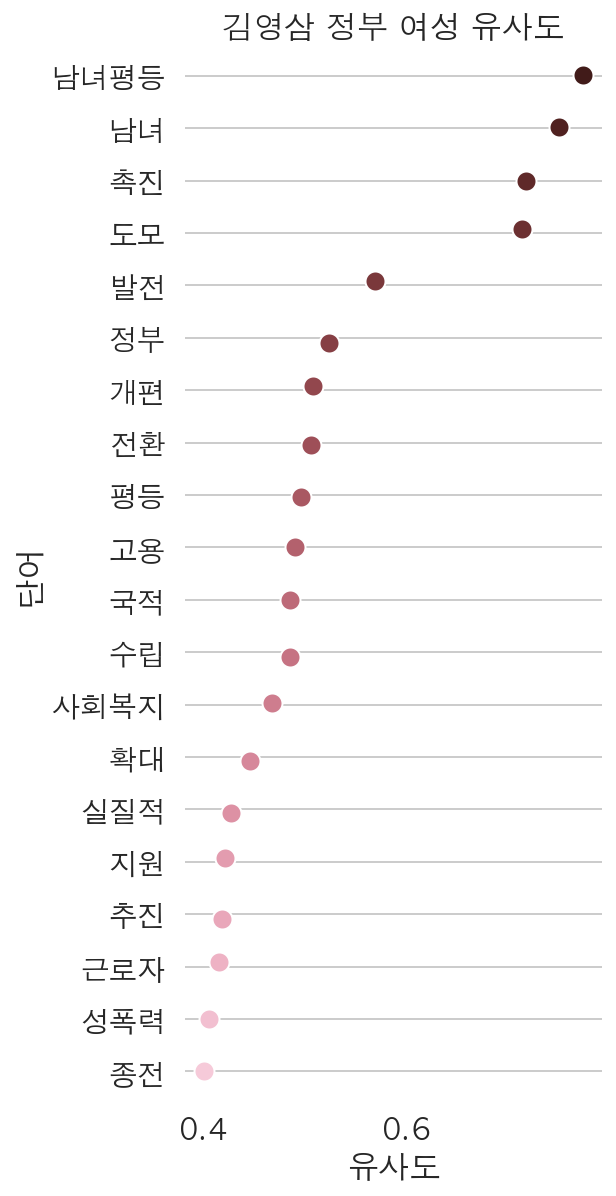

In [56]:
df = pd.DataFrame(model_government.wv.most_similar("여성", topn=20), columns=['단어','유사도'])

import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df, x_vars=df.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')
#g.set(xlable='유사도', ylabel="")
titles = df.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='김영삼 정부 여성 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)
#plt.savefig('김영삼 정권 유사도.png', bbox_inches='tight')

## 김대중 정권 
- 1998.02.25 ~ 2003.02.24

In [57]:
kimdaejoong = gender[(gender['제안일자'] > datetime.date(1998,2,25)) & 
                        (gender['제안일자'] < datetime.date(2003,2,24))]
kimdaejoong.shape

(92, 19)

In [58]:
model_government = Word2Vec(kimdaejoong['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=1)

2020-10-24 11:01:15,517 : INFO : collecting all words and their counts
2020-10-24 11:01:15,518 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-24 11:01:15,525 : INFO : collected 3438 word types from a corpus of 10656 raw words and 92 sentences
2020-10-24 11:01:15,526 : INFO : Loading a fresh vocabulary
2020-10-24 11:01:15,529 : INFO : effective_min_count=10 retains 198 unique words (5% of original 3438, drops 3240)
2020-10-24 11:01:15,531 : INFO : effective_min_count=10 leaves 3857 word corpus (36% of original 10656, drops 6799)
2020-10-24 11:01:15,533 : INFO : deleting the raw counts dictionary of 3438 items
2020-10-24 11:01:15,535 : INFO : sample=0.001 downsamples 168 most-common words
2020-10-24 11:01:15,536 : INFO : downsampling leaves estimated 2385 word corpus (61.9% of prior 3857)
2020-10-24 11:01:15,537 : INFO : estimated required memory for 198 words and 100 dimensions: 257400 bytes
2020-10-24 11:01:15,538 : INFO : resetting layer weights
202

2020-10-24 11:01:15,942 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:15,956 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:15,957 : INFO : EPOCH - 15 : training on 10656 raw words (2437 effective words) took 0.0s, 108427 effective words/s
2020-10-24 11:01:15,966 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:15,967 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:15,969 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:15,976 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:15,977 : INFO : EPOCH - 16 : training on 10656 raw words (2414 effective words) took 0.0s, 208102 effective words/s
2020-10-24 11:01:15,982 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:15,983 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-1

2020-10-24 11:01:16,327 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:16,332 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:16,333 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:16,341 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:16,343 : INFO : EPOCH - 32 : training on 10656 raw words (2389 effective words) took 0.0s, 136119 effective words/s
2020-10-24 11:01:16,349 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:16,355 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:16,356 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:16,366 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:16,367 : INFO : EPOCH - 33 : training on 10656 raw words (2367 effective words) took 0.0s, 113155 effective words/s
2020-1

2020-10-24 11:01:16,709 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:16,710 : INFO : EPOCH - 48 : training on 10656 raw words (2382 effective words) took 0.0s, 135192 effective words/s
2020-10-24 11:01:16,714 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:16,716 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:16,717 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:16,729 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:16,730 : INFO : EPOCH - 49 : training on 10656 raw words (2405 effective words) took 0.0s, 148718 effective words/s
2020-10-24 11:01:16,738 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:16,740 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:16,742 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-1

2020-10-24 11:01:17,096 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:17,102 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:17,104 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:17,106 : INFO : EPOCH - 65 : training on 10656 raw words (2404 effective words) took 0.0s, 140938 effective words/s
2020-10-24 11:01:17,114 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:17,122 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:17,126 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:17,133 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:17,137 : INFO : EPOCH - 66 : training on 10656 raw words (2371 effective words) took 0.0s, 102855 effective words/s
2020-10-24 11:01:17,147 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-1

2020-10-24 11:01:17,497 : INFO : EPOCH - 81 : training on 10656 raw words (2379 effective words) took 0.0s, 111022 effective words/s
2020-10-24 11:01:17,503 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:17,511 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:17,516 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:17,519 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:17,521 : INFO : EPOCH - 82 : training on 10656 raw words (2420 effective words) took 0.0s, 123555 effective words/s
2020-10-24 11:01:17,529 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:17,539 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:17,544 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:17,545 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-1

2020-10-24 11:01:17,890 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:17,902 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:17,903 : INFO : EPOCH - 98 : training on 10656 raw words (2368 effective words) took 0.0s, 136263 effective words/s
2020-10-24 11:01:17,908 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:17,911 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:01:17,912 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:01:17,924 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:01:17,926 : INFO : EPOCH - 99 : training on 10656 raw words (2360 effective words) took 0.0s, 113590 effective words/s
2020-10-24 11:01:17,932 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:01:17,934 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-1

In [59]:
print(model_government.wv.most_similar('여성'))

2020-10-24 11:01:17,960 : INFO : precomputing L2-norms of word weight vectors


[('합리적', 0.460597962141037), ('모성보호급여', 0.3984913229942322), ('부의', 0.3948163092136383), ('산전후', 0.3829946517944336), ('신설', 0.3726547360420227), ('정당', 0.3726503551006317), ('부담', 0.37050551176071167), ('활동', 0.35036128759384155), ('여성정책', 0.3443078398704529), ('추천', 0.3368295133113861)]


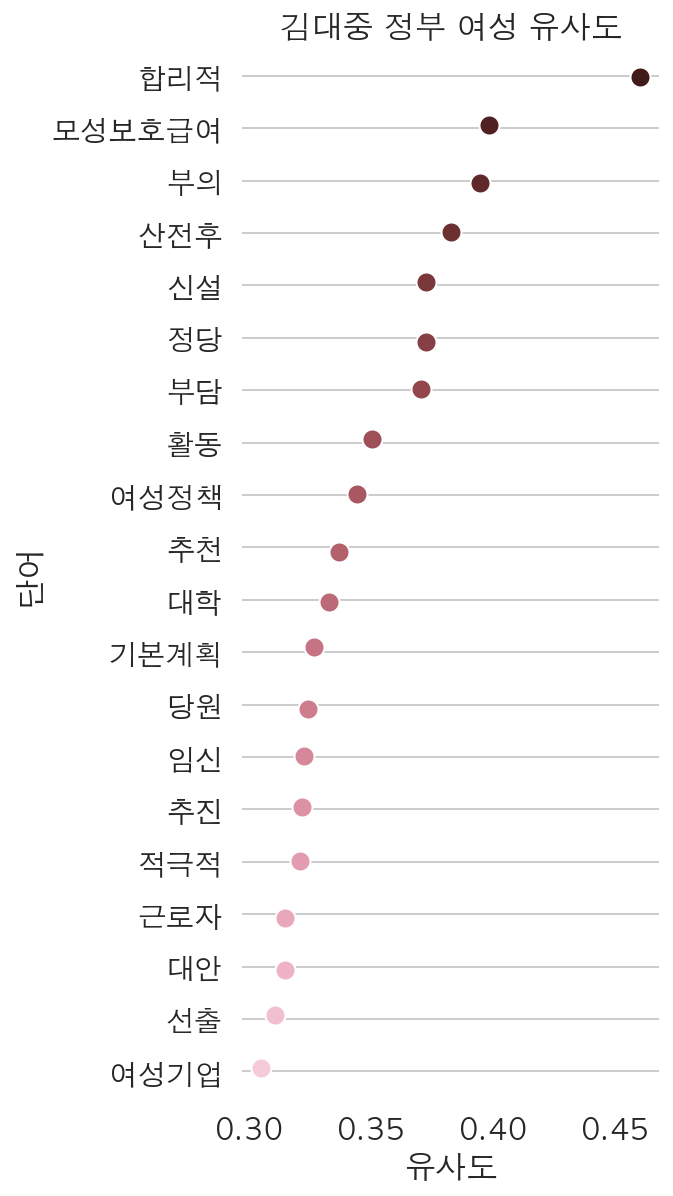

In [61]:
df = pd.DataFrame(model_government.wv.most_similar("여성", topn=20), columns=['단어','유사도'])

import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df, x_vars=df.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')
#g.set(xlable='유사도', ylabel="")
titles = df.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='김대중 정부 여성 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)
#plt.savefig('김영삼 정권 유사도.png', bbox_inches='tight')

## 노무현 정권  
- 2003.02.25 ~ 2004.04.14

In [62]:
romoohyun = gender[(gender['제안일자'] > datetime.date(2003,2,25)) & 
                        (gender['제안일자'] < datetime.date(2008,2,24))]
romoohyun.shape

(447, 19)

In [63]:
model_government = Word2Vec(romoohyun['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=1)

2020-10-24 11:02:02,951 : INFO : collecting all words and their counts
2020-10-24 11:02:02,956 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-24 11:02:02,973 : INFO : collected 9043 word types from a corpus of 50712 raw words and 447 sentences
2020-10-24 11:02:02,974 : INFO : Loading a fresh vocabulary
2020-10-24 11:02:02,983 : INFO : effective_min_count=10 retains 1050 unique words (11% of original 9043, drops 7993)
2020-10-24 11:02:02,984 : INFO : effective_min_count=10 leaves 32428 word corpus (63% of original 50712, drops 18284)
2020-10-24 11:02:02,989 : INFO : deleting the raw counts dictionary of 9043 items
2020-10-24 11:02:02,990 : INFO : sample=0.001 downsamples 65 most-common words
2020-10-24 11:02:02,992 : INFO : downsampling leaves estimated 29199 word corpus (90.0% of prior 32428)
2020-10-24 11:02:02,996 : INFO : estimated required memory for 1050 words and 100 dimensions: 1365000 bytes
2020-10-24 11:02:02,997 : INFO : resetting layer wei

2020-10-24 11:02:05,188 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:05,190 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:05,228 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:05,230 : INFO : EPOCH - 15 : training on 50712 raw words (29207 effective words) took 0.1s, 249295 effective words/s
2020-10-24 11:02:05,305 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:05,306 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:05,307 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:05,341 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:05,343 : INFO : EPOCH - 16 : training on 50712 raw words (29190 effective words) took 0.1s, 267966 effective words/s
2020-10-24 11:02:05,421 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:02:07,279 : INFO : EPOCH - 31 : training on 50712 raw words (29247 effective words) took 0.1s, 225427 effective words/s
2020-10-24 11:02:07,353 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:07,356 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:07,358 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:07,390 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:07,390 : INFO : EPOCH - 32 : training on 50712 raw words (29187 effective words) took 0.1s, 269722 effective words/s
2020-10-24 11:02:07,477 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:07,483 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:07,484 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:07,532 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-10-24 11:02:09,395 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:09,398 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:09,430 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:09,430 : INFO : EPOCH - 48 : training on 50712 raw words (29198 effective words) took 0.1s, 246960 effective words/s
2020-10-24 11:02:09,514 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:09,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:09,520 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:09,559 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:09,560 : INFO : EPOCH - 49 : training on 50712 raw words (29149 effective words) took 0.1s, 231949 effective words/s
2020-10-24 11:02:09,638 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:02:11,429 : INFO : EPOCH - 64 : training on 50712 raw words (29195 effective words) took 0.1s, 219889 effective words/s
2020-10-24 11:02:11,506 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:11,510 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:11,512 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:11,548 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:11,549 : INFO : EPOCH - 65 : training on 50712 raw words (29210 effective words) took 0.1s, 250972 effective words/s
2020-10-24 11:02:11,626 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:11,628 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:11,632 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:11,671 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-10-24 11:02:13,390 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:13,394 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:13,423 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:13,424 : INFO : EPOCH - 81 : training on 50712 raw words (29216 effective words) took 0.1s, 241061 effective words/s
2020-10-24 11:02:13,507 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:13,510 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:13,512 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:13,540 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:13,540 : INFO : EPOCH - 82 : training on 50712 raw words (29155 effective words) took 0.1s, 262031 effective words/s
2020-10-24 11:02:13,616 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:02:15,440 : INFO : EPOCH - 97 : training on 50712 raw words (29227 effective words) took 0.2s, 189976 effective words/s
2020-10-24 11:02:15,514 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:15,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:15,516 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:15,553 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:02:15,554 : INFO : EPOCH - 98 : training on 50712 raw words (29247 effective words) took 0.1s, 276903 effective words/s
2020-10-24 11:02:15,679 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:02:15,680 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:02:15,686 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:02:15,718 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

In [64]:
print(model_government.wv.most_similar('여성'))

2020-10-24 11:02:15,857 : INFO : precomputing L2-norms of word weight vectors


[('남성', 0.5338213443756104), ('유산', 0.4534717798233032), ('수준', 0.38537073135375977), ('성별', 0.36957597732543945), ('임신기간', 0.3652704954147339), ('사회참여', 0.35655301809310913), ('여성들', 0.3518892228603363), ('노동', 0.3512657880783081), ('현실적', 0.3505662977695465), ('임기만료', 0.348691463470459)]


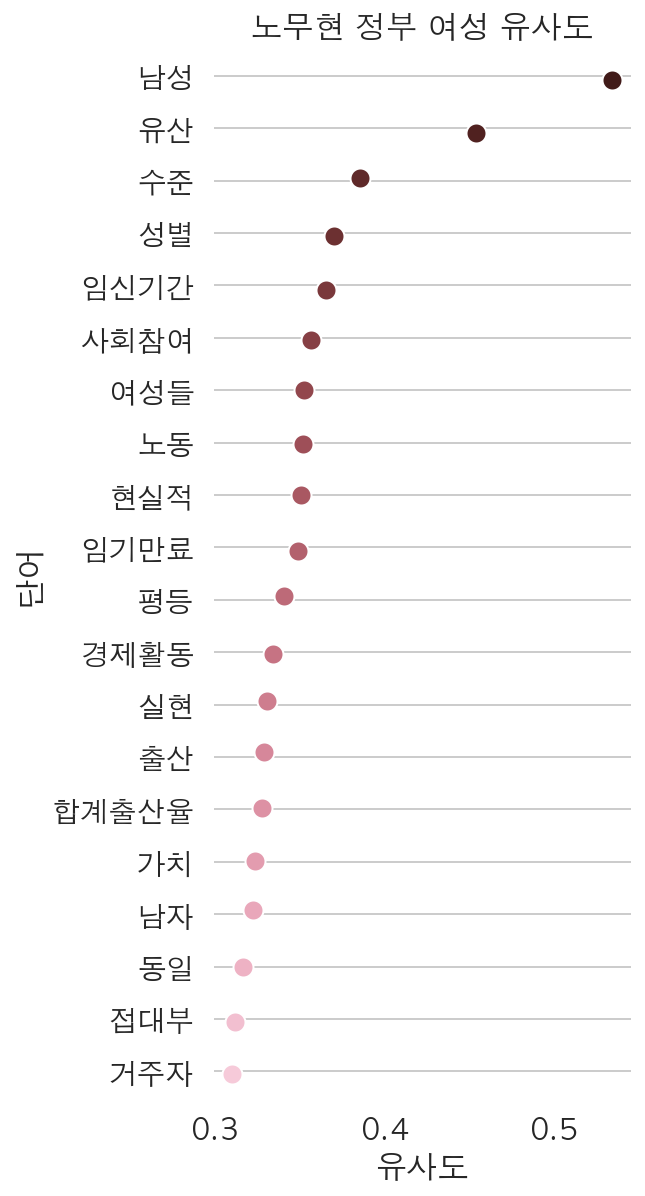

In [66]:
df = pd.DataFrame(model_government.wv.most_similar("여성", topn=20), columns=['단어','유사도'])

import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df, x_vars=df.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')
#g.set(xlable='유사도', ylabel="")
titles = df.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='노무현 정부 여성 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)
#plt.savefig('김영삼 정권 유사도.png', bbox_inches='tight')

## 이명박 정권
- 2008.02.25 ~ 2013.02.24

In [67]:
leemyungbak = gender[(gender['제안일자'] > datetime.date(2008,2,25)) & 
                        (gender['제안일자'] < datetime.date(2013,2,24))]
leemyungbak.shape

(1131, 19)

In [68]:
model_government = Word2Vec(leemyungbak['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=1)

2020-10-24 11:03:06,762 : INFO : collecting all words and their counts
2020-10-24 11:03:06,763 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-24 11:03:06,791 : INFO : collected 12054 word types from a corpus of 100761 raw words and 1131 sentences
2020-10-24 11:03:06,792 : INFO : Loading a fresh vocabulary
2020-10-24 11:03:06,801 : INFO : effective_min_count=10 retains 1797 unique words (14% of original 12054, drops 10257)
2020-10-24 11:03:06,802 : INFO : effective_min_count=10 leaves 76627 word corpus (76% of original 100761, drops 24134)
2020-10-24 11:03:06,808 : INFO : deleting the raw counts dictionary of 12054 items
2020-10-24 11:03:06,810 : INFO : sample=0.001 downsamples 52 most-common words
2020-10-24 11:03:06,811 : INFO : downsampling leaves estimated 69143 word corpus (90.2% of prior 76627)
2020-10-24 11:03:06,816 : INFO : estimated required memory for 1797 words and 100 dimensions: 2336100 bytes
2020-10-24 11:03:06,817 : INFO : resetting la

2020-10-24 11:03:11,697 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:11,772 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:11,786 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:11,787 : INFO : EPOCH - 15 : training on 100761 raw words (69219 effective words) took 0.3s, 205307 effective words/s
2020-10-24 11:03:11,992 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:12,011 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:12,092 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:12,102 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:12,103 : INFO : EPOCH - 16 : training on 100761 raw words (69122 effective words) took 0.3s, 224658 effective words/s
2020-10-24 11:03:12,353 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-10-24 11:03:16,145 : INFO : EPOCH - 31 : training on 100761 raw words (69078 effective words) took 0.3s, 265504 effective words/s
2020-10-24 11:03:16,340 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:16,353 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:16,409 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:16,415 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:16,416 : INFO : EPOCH - 32 : training on 100761 raw words (69103 effective words) took 0.3s, 261348 effective words/s
2020-10-24 11:03:16,579 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:16,598 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:16,645 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:16,657 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-10-24 11:03:20,769 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:20,833 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:20,838 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:20,839 : INFO : EPOCH - 48 : training on 100761 raw words (69200 effective words) took 0.3s, 238764 effective words/s
2020-10-24 11:03:21,002 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:21,022 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:21,085 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:21,089 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:21,090 : INFO : EPOCH - 49 : training on 100761 raw words (69127 effective words) took 0.2s, 281924 effective words/s
2020-10-24 11:03:21,297 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-10-24 11:03:25,240 : INFO : EPOCH - 64 : training on 100761 raw words (69193 effective words) took 0.3s, 239886 effective words/s
2020-10-24 11:03:25,449 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:25,463 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:25,515 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:25,519 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:25,520 : INFO : EPOCH - 65 : training on 100761 raw words (69231 effective words) took 0.3s, 252353 effective words/s
2020-10-24 11:03:25,733 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:25,752 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:25,809 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:25,816 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-10-24 11:03:29,879 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:29,948 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:29,953 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:29,954 : INFO : EPOCH - 81 : training on 100761 raw words (69220 effective words) took 0.3s, 245114 effective words/s
2020-10-24 11:03:30,170 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:30,198 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:30,273 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:30,278 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:30,280 : INFO : EPOCH - 82 : training on 100761 raw words (69011 effective words) took 0.3s, 215810 effective words/s
2020-10-24 11:03:30,486 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-10-24 11:03:34,625 : INFO : EPOCH - 97 : training on 100761 raw words (69203 effective words) took 0.2s, 280305 effective words/s
2020-10-24 11:03:34,795 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:34,810 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:34,860 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:34,868 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:03:34,868 : INFO : EPOCH - 98 : training on 100761 raw words (69141 effective words) took 0.2s, 292835 effective words/s
2020-10-24 11:03:35,030 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:03:35,051 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:03:35,105 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:03:35,114 : INFO : worker thread finished; awaiting finish of 0 more threads
20

In [69]:
print(model_government.wv.most_similar('여성'))

2020-10-24 11:03:35,408 : INFO : precomputing L2-norms of word weight vectors


[('남성', 0.6414812207221985), ('정치참여', 0.4862114191055298), ('여성비하적', 0.47728925943374634), ('우리나라', 0.4640374779701233), ('내포', 0.46026912331581116), ('여성조합원', 0.44830793142318726), ('진출', 0.4250764846801758), ('고정관념', 0.4235292077064514), ('비율', 0.4221608340740204), ('촉진법', 0.4195801019668579)]


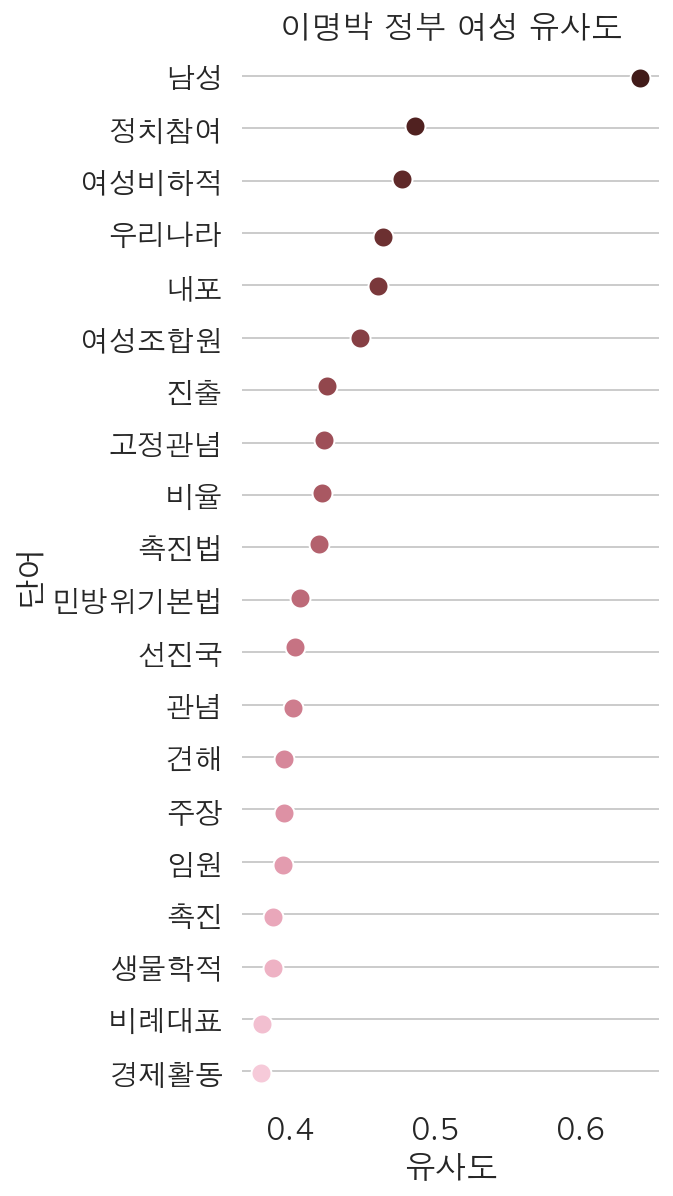

In [71]:
df = pd.DataFrame(model_government.wv.most_similar("여성", topn=20), columns=['단어','유사도'])

import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df, x_vars=df.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')
#g.set(xlable='유사도', ylabel="")
titles = df.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='이명박 정부 여성 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)
#plt.savefig('김영삼 정권 유사도.png', bbox_inches='tight')

## 박근혜 정권
- 2013.02.25 ~ 2017.03.13

In [72]:
parkkeunhye = gender[(gender['제안일자'] > datetime.date(2013,2,25)) & 
                        (gender['제안일자'] < datetime.date(2017,5,10))]
parkkeunhye.shape

(1121, 19)

In [73]:
model_government = Word2Vec(parkkeunhye['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=1)

2020-10-24 11:04:10,552 : INFO : collecting all words and their counts
2020-10-24 11:04:10,555 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-24 11:04:10,579 : INFO : collected 10179 word types from a corpus of 83614 raw words and 1121 sentences
2020-10-24 11:04:10,580 : INFO : Loading a fresh vocabulary
2020-10-24 11:04:10,588 : INFO : effective_min_count=10 retains 1538 unique words (15% of original 10179, drops 8641)
2020-10-24 11:04:10,589 : INFO : effective_min_count=10 leaves 63284 word corpus (75% of original 83614, drops 20330)
2020-10-24 11:04:10,595 : INFO : deleting the raw counts dictionary of 10179 items
2020-10-24 11:04:10,596 : INFO : sample=0.001 downsamples 52 most-common words
2020-10-24 11:04:10,597 : INFO : downsampling leaves estimated 56852 word corpus (89.8% of prior 63284)
2020-10-24 11:04:10,602 : INFO : estimated required memory for 1538 words and 100 dimensions: 1999400 bytes
2020-10-24 11:04:10,603 : INFO : resetting layer

2020-10-24 11:04:14,546 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:14,549 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:14,574 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:14,576 : INFO : EPOCH - 15 : training on 83614 raw words (56838 effective words) took 0.2s, 252478 effective words/s
2020-10-24 11:04:14,774 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:14,775 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:14,791 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:14,796 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:14,797 : INFO : EPOCH - 16 : training on 83614 raw words (56848 effective words) took 0.2s, 264755 effective words/s
2020-10-24 11:04:14,955 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:04:18,345 : INFO : EPOCH - 31 : training on 83614 raw words (56732 effective words) took 0.2s, 276655 effective words/s
2020-10-24 11:04:18,562 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:18,564 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:18,573 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:18,592 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:18,593 : INFO : EPOCH - 32 : training on 83614 raw words (56779 effective words) took 0.2s, 235993 effective words/s
2020-10-24 11:04:18,760 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:18,772 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:18,775 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:18,795 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-10-24 11:04:22,329 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:22,334 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:22,350 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:22,351 : INFO : EPOCH - 48 : training on 83614 raw words (56855 effective words) took 0.2s, 278034 effective words/s
2020-10-24 11:04:22,518 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:22,520 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:22,521 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:22,545 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:22,546 : INFO : EPOCH - 49 : training on 83614 raw words (56824 effective words) took 0.2s, 304725 effective words/s
2020-10-24 11:04:22,721 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:04:25,995 : INFO : EPOCH - 64 : training on 83614 raw words (56932 effective words) took 0.2s, 294421 effective words/s
2020-10-24 11:04:26,173 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:26,175 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:26,176 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:26,227 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:26,228 : INFO : EPOCH - 65 : training on 83614 raw words (56821 effective words) took 0.2s, 250381 effective words/s
2020-10-24 11:04:26,382 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:26,387 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:26,390 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:26,401 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-10-24 11:04:29,554 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:29,560 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:29,562 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:29,563 : INFO : EPOCH - 81 : training on 83614 raw words (56756 effective words) took 0.2s, 318822 effective words/s
2020-10-24 11:04:29,762 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:29,763 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:29,766 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:29,787 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:29,788 : INFO : EPOCH - 82 : training on 83614 raw words (56731 effective words) took 0.2s, 257438 effective words/s
2020-10-24 11:04:29,952 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:04:32,947 : INFO : EPOCH - 97 : training on 83614 raw words (56890 effective words) took 0.2s, 284175 effective words/s
2020-10-24 11:04:33,157 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:33,164 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:33,173 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:33,196 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:33,197 : INFO : EPOCH - 98 : training on 83614 raw words (56873 effective words) took 0.2s, 234705 effective words/s
2020-10-24 11:04:33,364 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:33,369 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:33,372 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:33,390 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

In [74]:
print(model_government.wv.most_similar('여성'))

2020-10-24 11:04:33,580 : INFO : precomputing L2-norms of word weight vectors


[('남성', 0.5451536178588867), ('정치참여', 0.5238741636276245), ('성별', 0.5133988857269287), ('경제활동', 0.5130733251571655), ('전국지역구총수', 0.49726027250289917), ('경력단절', 0.48560261726379395), ('남녀', 0.4797888398170471), ('격차', 0.4728984832763672), ('촉진', 0.4689444601535797), ('지역구지방의회의원선거', 0.4677959084510803)]


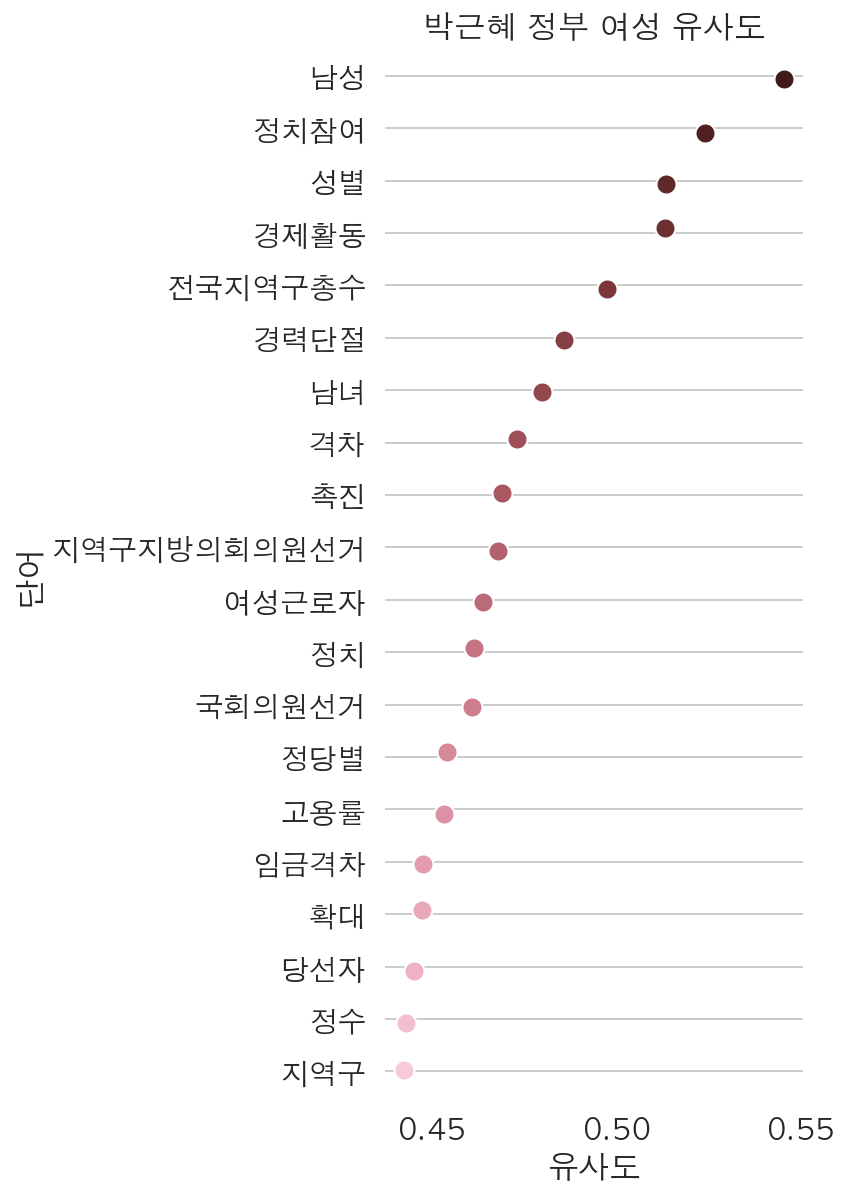

In [75]:
df = pd.DataFrame(model_government.wv.most_similar("여성", topn=20), columns=['단어','유사도'])

import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df, x_vars=df.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')
#g.set(xlable='유사도', ylabel="")
titles = df.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='박근혜 정부 여성 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)
#plt.savefig('김영삼 정권 유사도.png', bbox_inches='tight')

## 문재인 정권 
- 2017.05.10 ~

In [76]:
moonjaein = gender[(gender['제안일자'] > datetime.date(2017,5,10))]
moonjaein.shape

(1410, 19)

In [77]:
model_government = Word2Vec(moonjaein['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=1)

2020-10-24 11:04:49,762 : INFO : collecting all words and their counts
2020-10-24 11:04:49,764 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-24 11:04:49,788 : INFO : collected 10786 word types from a corpus of 94635 raw words and 1410 sentences
2020-10-24 11:04:49,789 : INFO : Loading a fresh vocabulary
2020-10-24 11:04:49,798 : INFO : effective_min_count=10 retains 1652 unique words (15% of original 10786, drops 9134)
2020-10-24 11:04:49,799 : INFO : effective_min_count=10 leaves 73240 word corpus (77% of original 94635, drops 21395)
2020-10-24 11:04:49,805 : INFO : deleting the raw counts dictionary of 10786 items
2020-10-24 11:04:49,806 : INFO : sample=0.001 downsamples 50 most-common words
2020-10-24 11:04:49,809 : INFO : downsampling leaves estimated 65873 word corpus (89.9% of prior 73240)
2020-10-24 11:04:49,814 : INFO : estimated required memory for 1652 words and 100 dimensions: 2147600 bytes
2020-10-24 11:04:49,815 : INFO : resetting layer

2020-10-24 11:04:54,229 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:54,272 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:54,302 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:54,303 : INFO : EPOCH - 15 : training on 94635 raw words (65839 effective words) took 0.3s, 229950 effective words/s
2020-10-24 11:04:54,525 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:54,528 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:54,569 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:54,595 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:54,596 : INFO : EPOCH - 16 : training on 94635 raw words (65856 effective words) took 0.3s, 230704 effective words/s
2020-10-24 11:04:54,824 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:04:58,416 : INFO : EPOCH - 31 : training on 94635 raw words (65887 effective words) took 0.2s, 266845 effective words/s
2020-10-24 11:04:58,596 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:58,598 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:58,624 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:58,638 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:04:58,639 : INFO : EPOCH - 32 : training on 94635 raw words (65845 effective words) took 0.2s, 308764 effective words/s
2020-10-24 11:04:58,826 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:04:58,833 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:04:58,866 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:04:58,899 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-10-24 11:05:03,010 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:05:03,041 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:05:03,075 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:05:03,076 : INFO : EPOCH - 48 : training on 94635 raw words (65861 effective words) took 0.3s, 213576 effective words/s
2020-10-24 11:05:03,257 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:05:03,270 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:05:03,306 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:05:03,329 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:05:03,331 : INFO : EPOCH - 49 : training on 94635 raw words (65903 effective words) took 0.2s, 265637 effective words/s
2020-10-24 11:05:03,558 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:05:07,209 : INFO : EPOCH - 64 : training on 94635 raw words (65929 effective words) took 0.3s, 217223 effective words/s
2020-10-24 11:05:07,380 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:05:07,389 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:05:07,413 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:05:07,434 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:05:07,435 : INFO : EPOCH - 65 : training on 94635 raw words (65948 effective words) took 0.2s, 306240 effective words/s
2020-10-24 11:05:07,603 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:05:07,605 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:05:07,633 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:05:07,663 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-10-24 11:05:11,337 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:05:11,372 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:05:11,407 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:05:11,408 : INFO : EPOCH - 81 : training on 94635 raw words (65860 effective words) took 0.3s, 212899 effective words/s
2020-10-24 11:05:11,588 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:05:11,599 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:05:11,624 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:05:11,650 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:05:11,651 : INFO : EPOCH - 82 : training on 94635 raw words (65856 effective words) took 0.2s, 280109 effective words/s
2020-10-24 11:05:11,832 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-10-24 11:05:15,442 : INFO : EPOCH - 97 : training on 94635 raw words (65854 effective words) took 0.3s, 233598 effective words/s
2020-10-24 11:05:15,620 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:05:15,627 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:05:15,662 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:05:15,682 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-24 11:05:15,683 : INFO : EPOCH - 98 : training on 94635 raw words (65872 effective words) took 0.2s, 279283 effective words/s
2020-10-24 11:05:15,909 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-24 11:05:15,910 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-24 11:05:15,950 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-24 11:05:15,983 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

In [78]:
print(model_government.wv.most_similar('여성'))

2020-10-24 11:05:16,227 : INFO : precomputing L2-norms of word weight vectors


[('남성', 0.6876175403594971), ('우리나라', 0.5248585939407349), ('세계', 0.5203261971473694), ('유리천장', 0.5009262561798096), ('재취업', 0.4835994839668274), ('중견기업', 0.46965593099594116), ('기업', 0.46595925092697144), ('노력', 0.4635297656059265), ('개국', 0.46158450841903687), ('경제활동', 0.44683951139450073)]


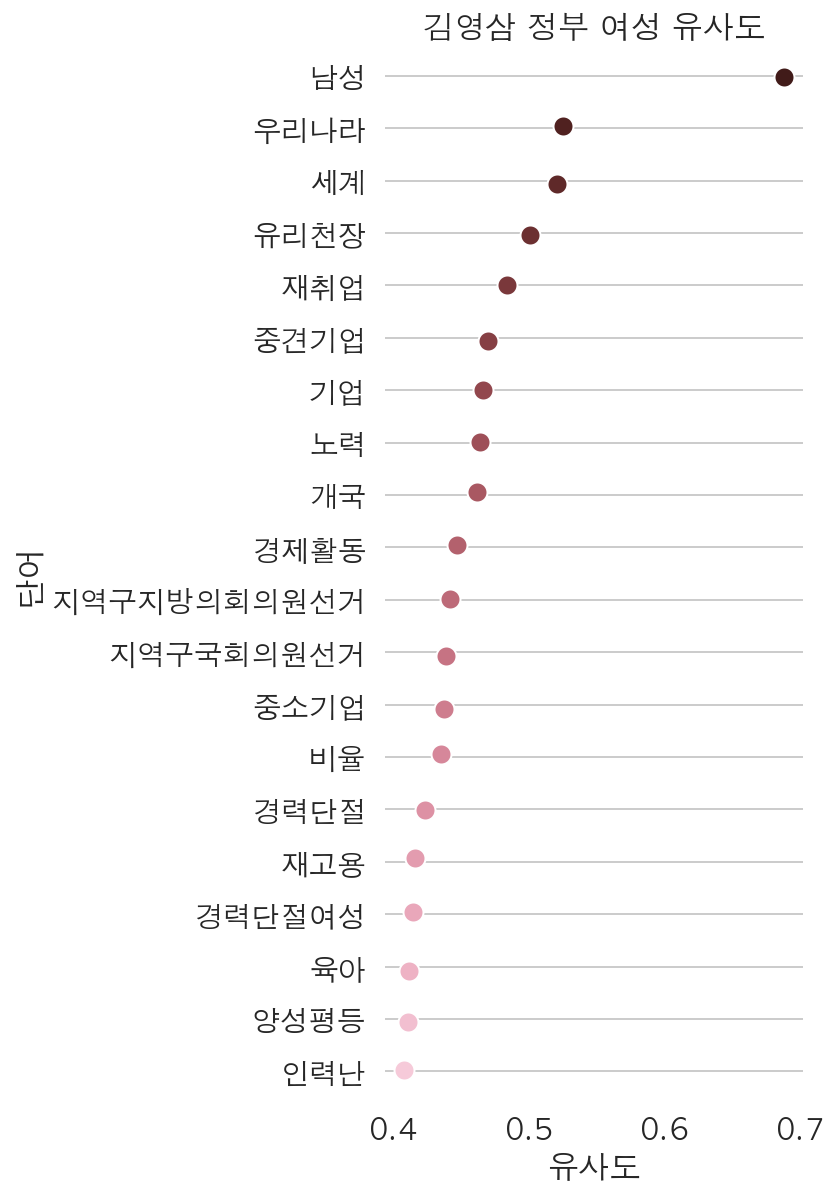

In [79]:
df = pd.DataFrame(model_government.wv.most_similar("여성", topn=20), columns=['단어','유사도'])

import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df, x_vars=df.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')
#g.set(xlable='유사도', ylabel="")
titles = df.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='김영삼 정부 여성 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)
#plt.savefig('김영삼 정권 유사도.png', bbox_inches='tight')